This notebook purpose is to generate our history plots and to calculate the geometric mean. This is the geometric mean of the metric differences between versions, as a way to check for tendencies. It is the one we actually used in the paper. We also compare the geometric means with the Wilcoxon test.

In [39]:
#These are all the necessary imports for this notebook. Make sure you have all of the dependencies installed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from scipy.stats.mstats import gmean
from matplotlib.ticker import MultipleLocator

In [40]:
data_java = pd.read_csv('.\Data\projects_java.csv')
data_android = pd.read_csv('.\Data\projects_android.csv')

In [41]:
data_all = data_java.append(data_android)

First of all, we made the history plots for all projects considering each metric.

In [42]:
def get_cicd_version(data):
    data = data.reset_index()
    for i in range(len(data['Period'])):
        if data['Period'][i] != "Before CI/CD":
            return data['Version'][i]

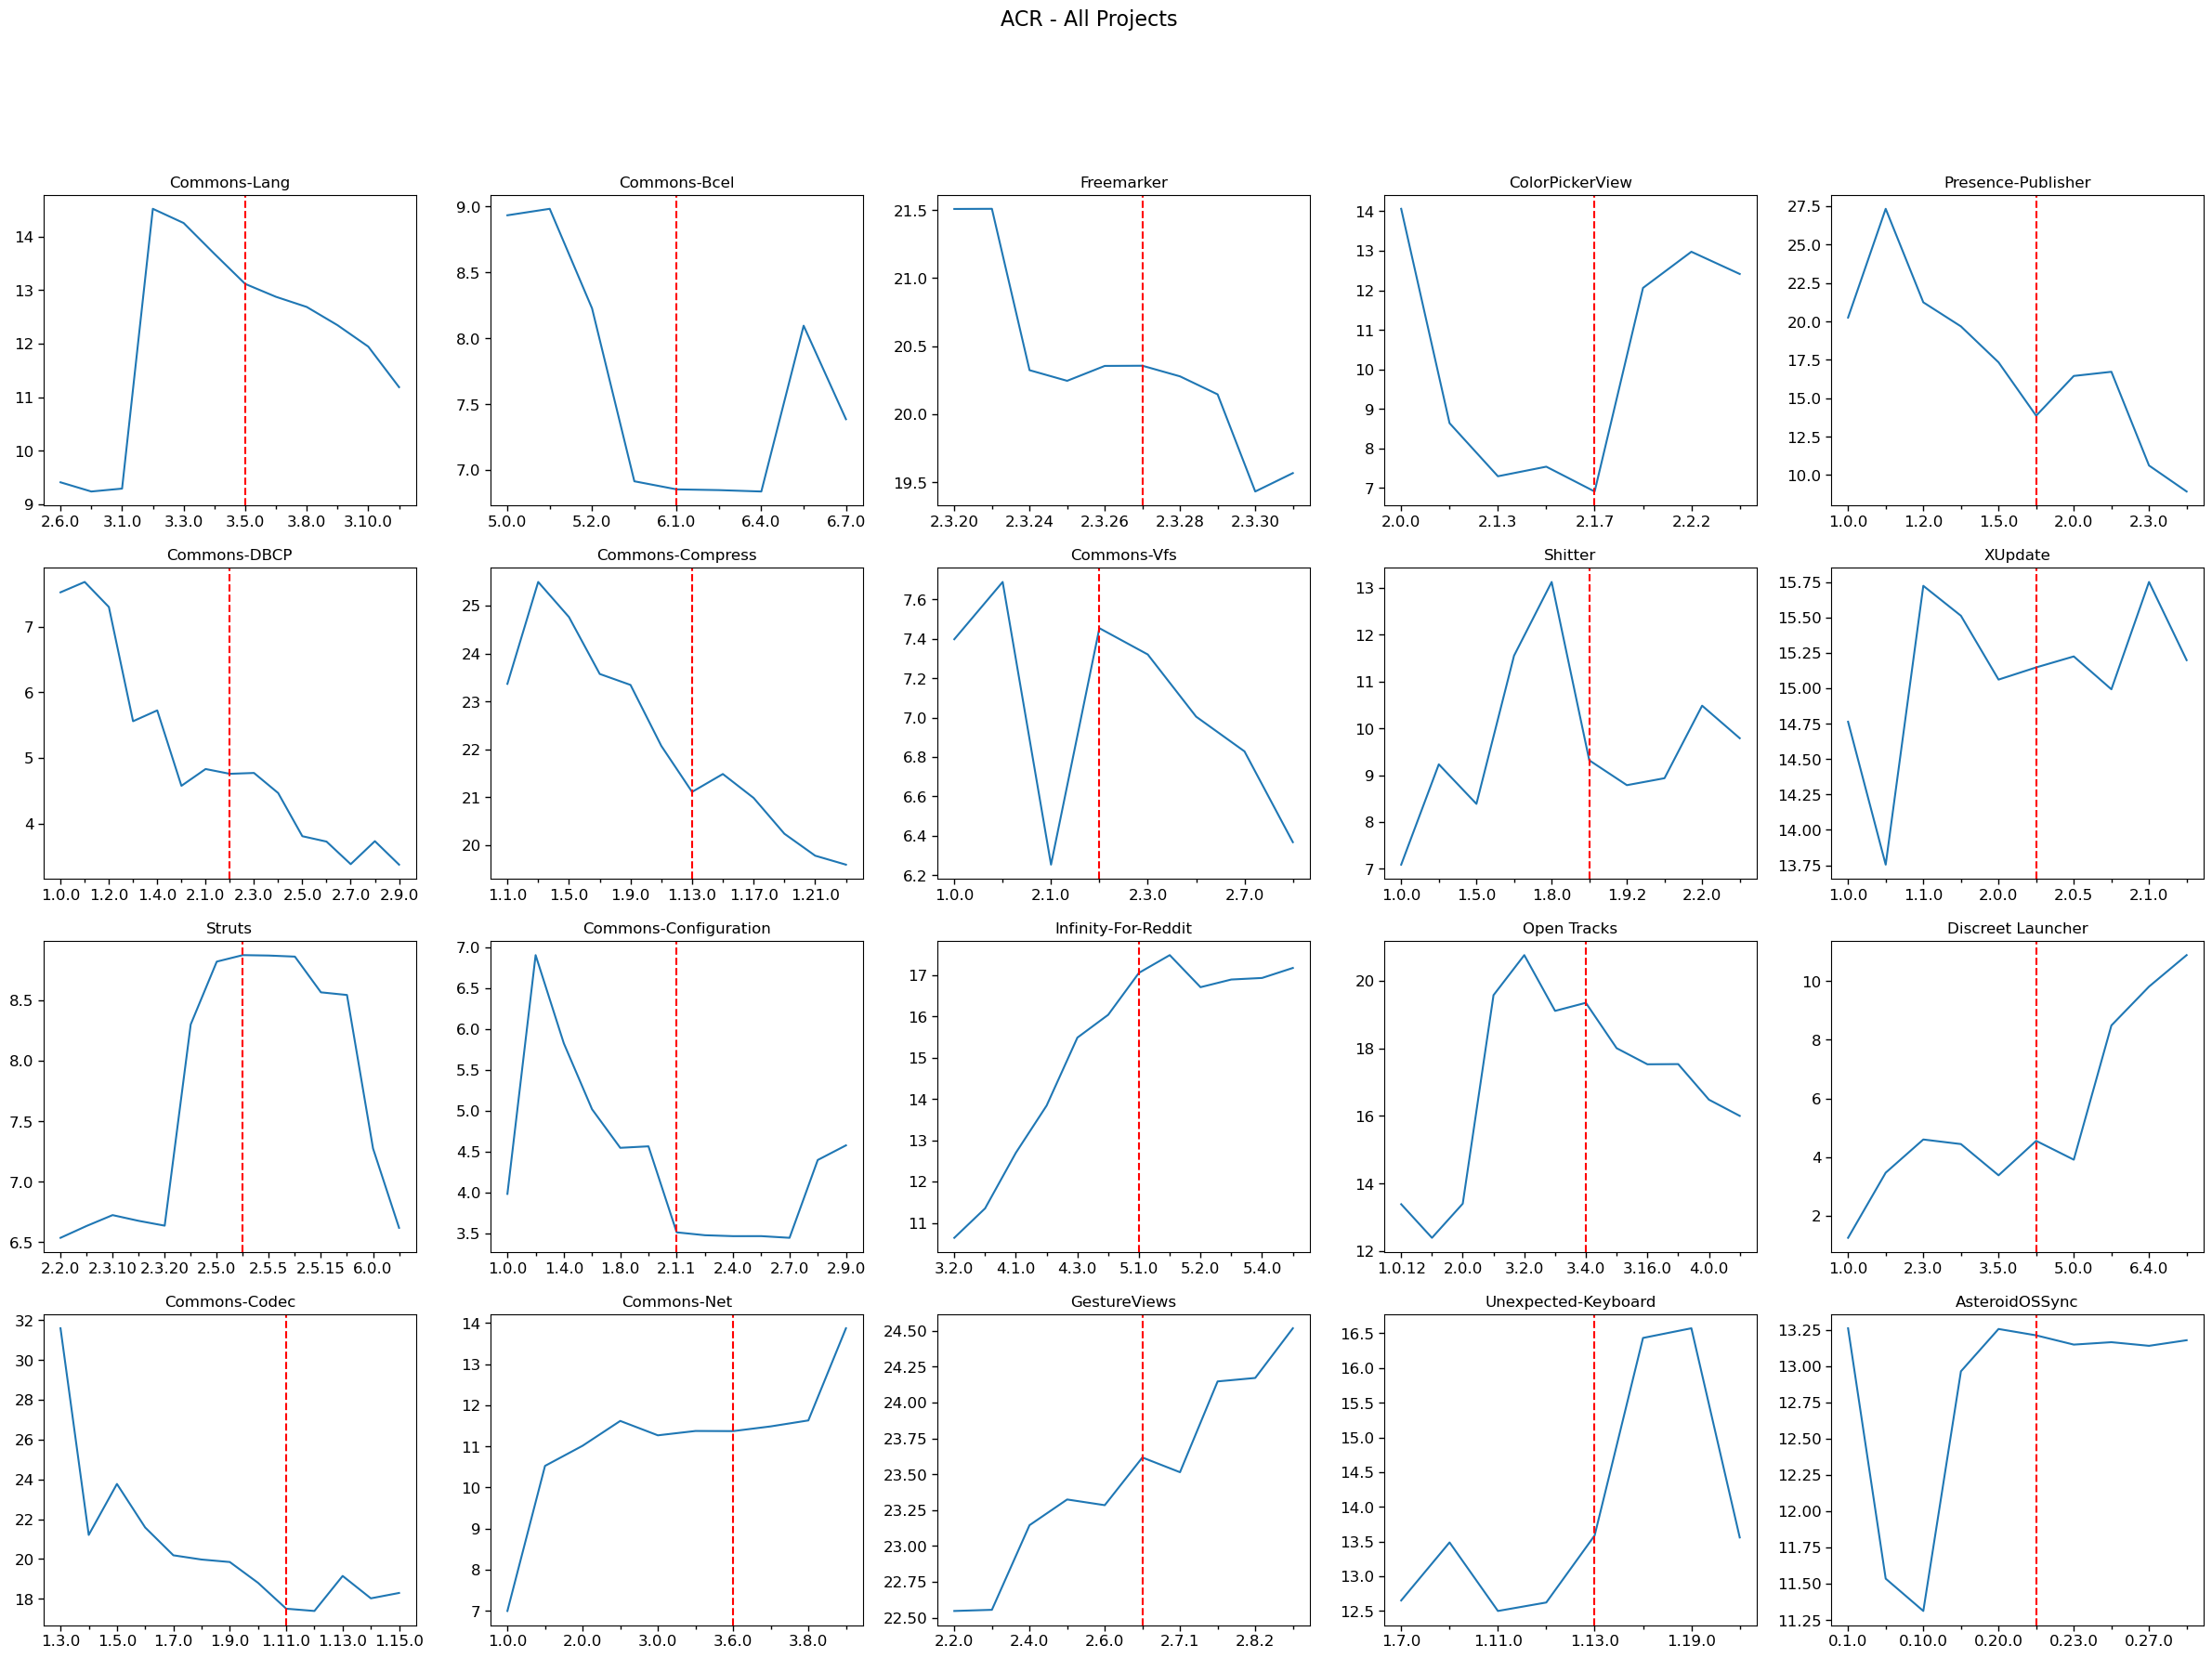

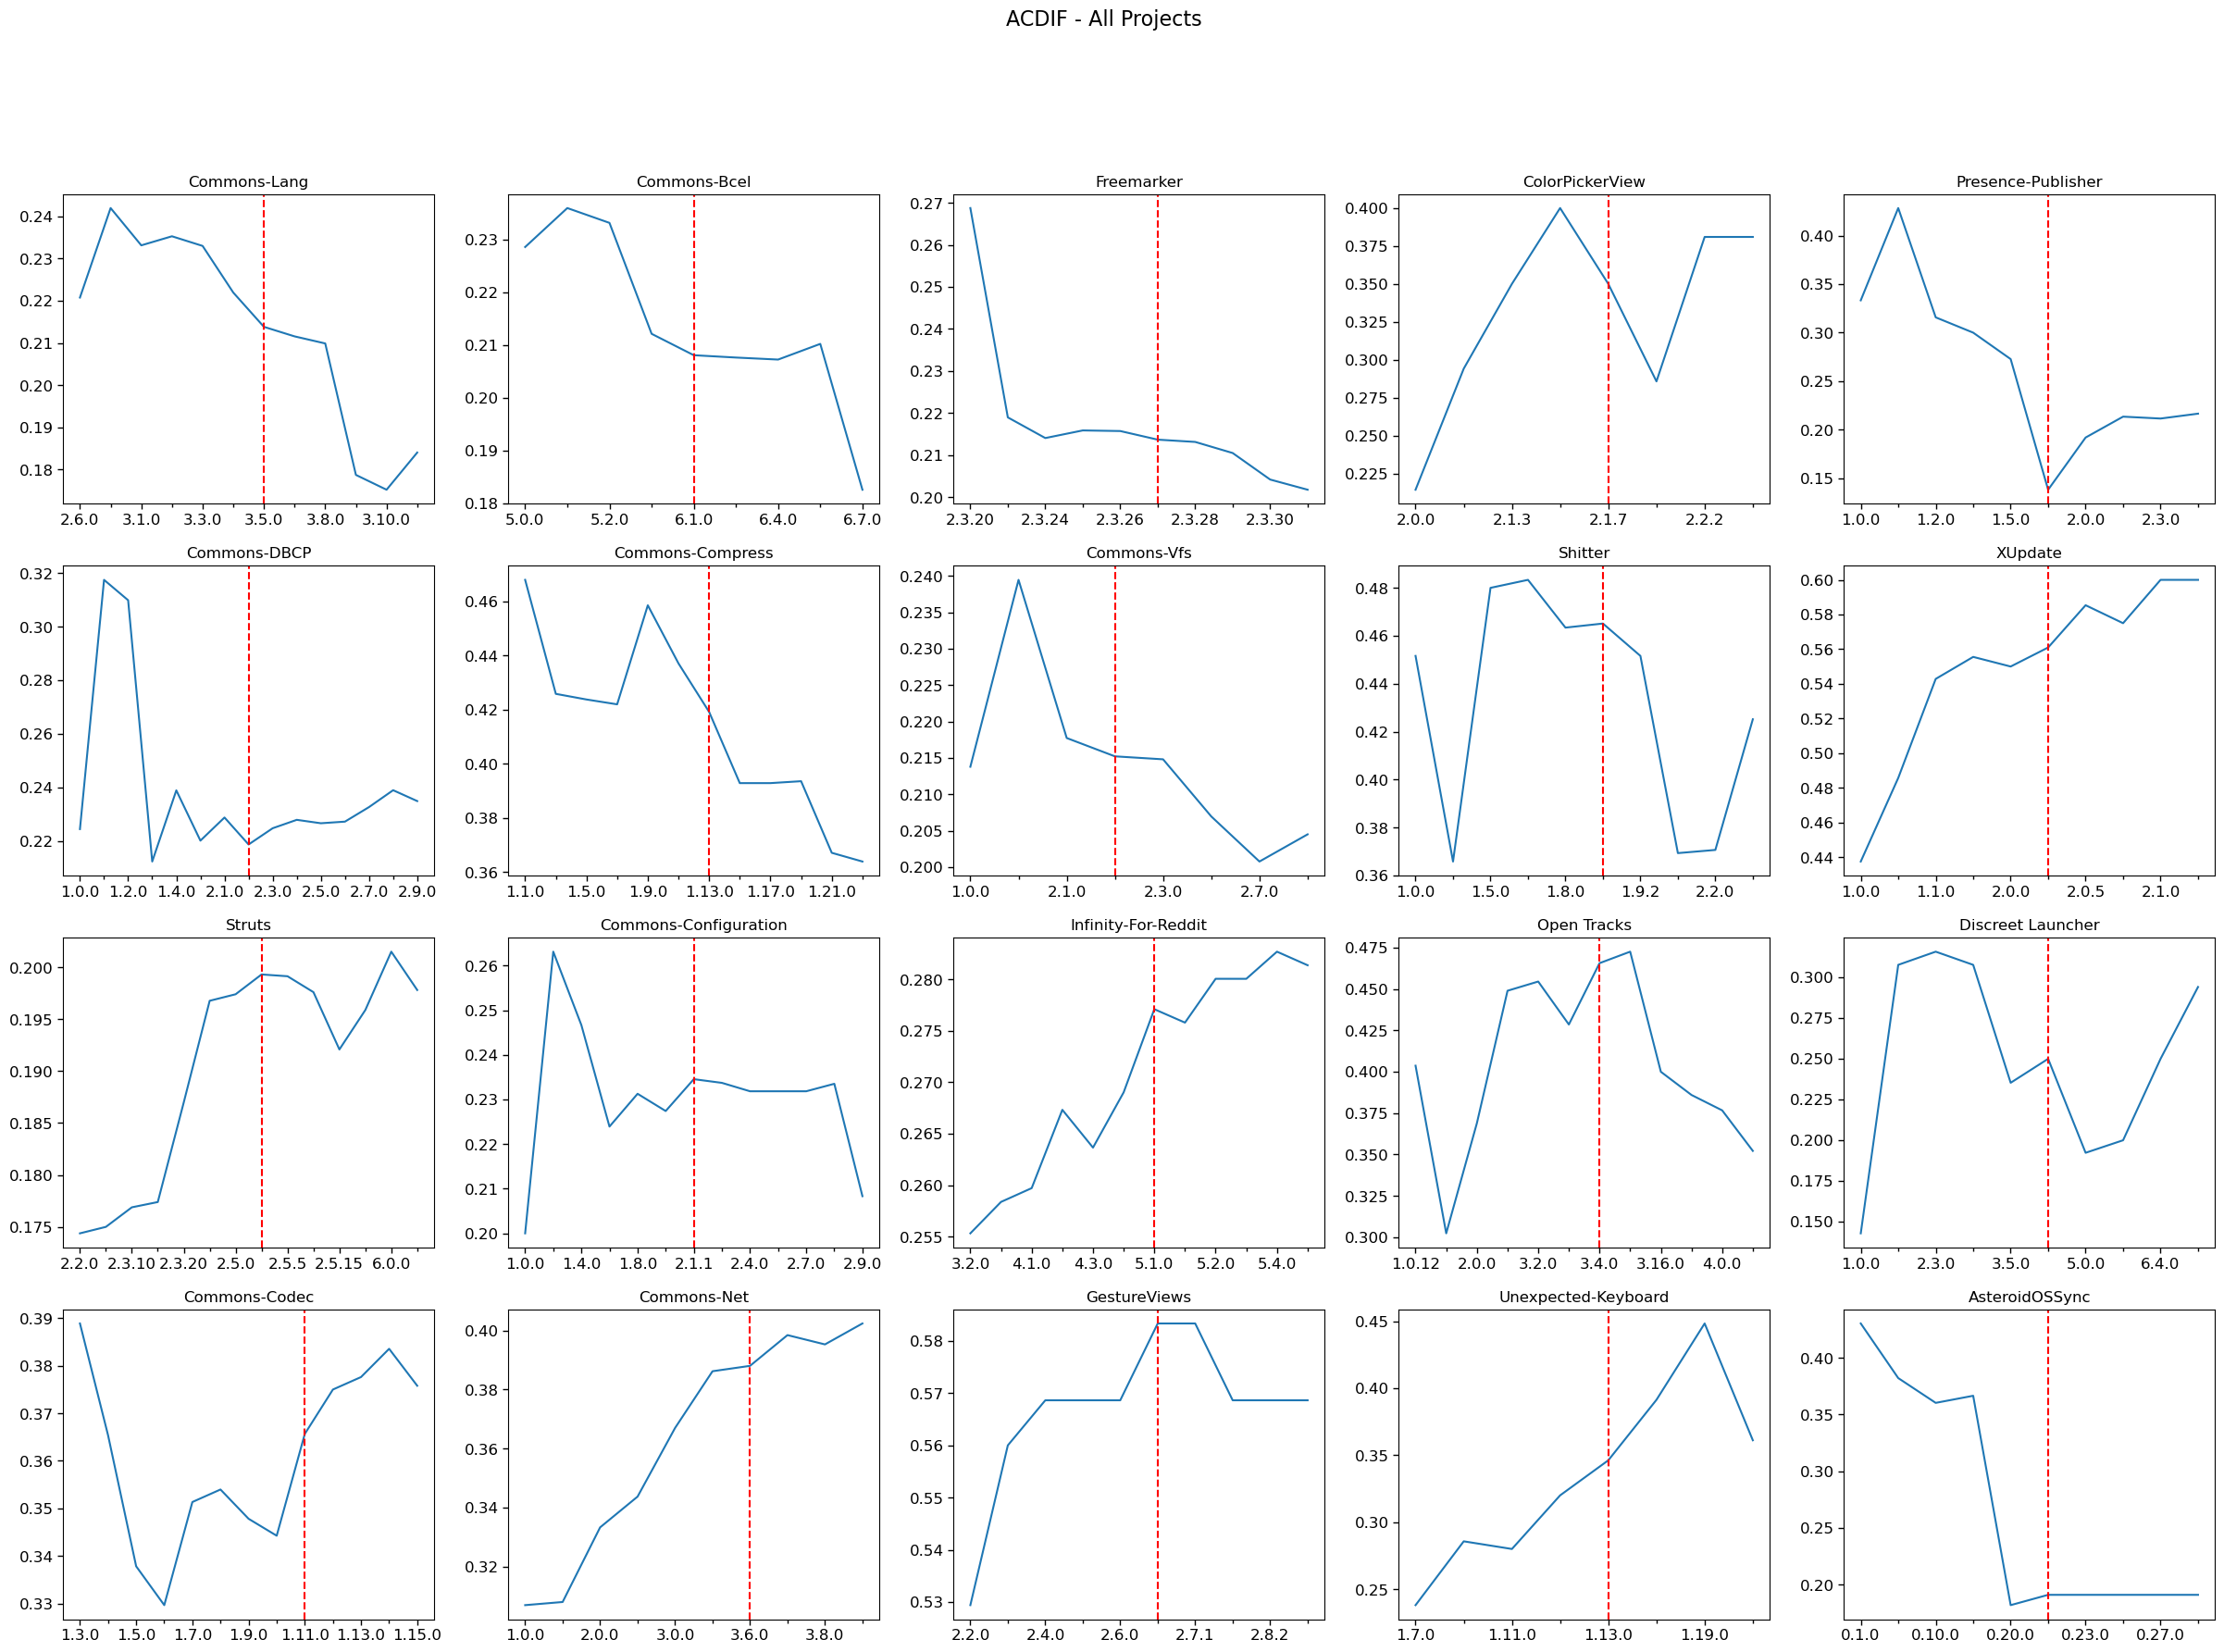

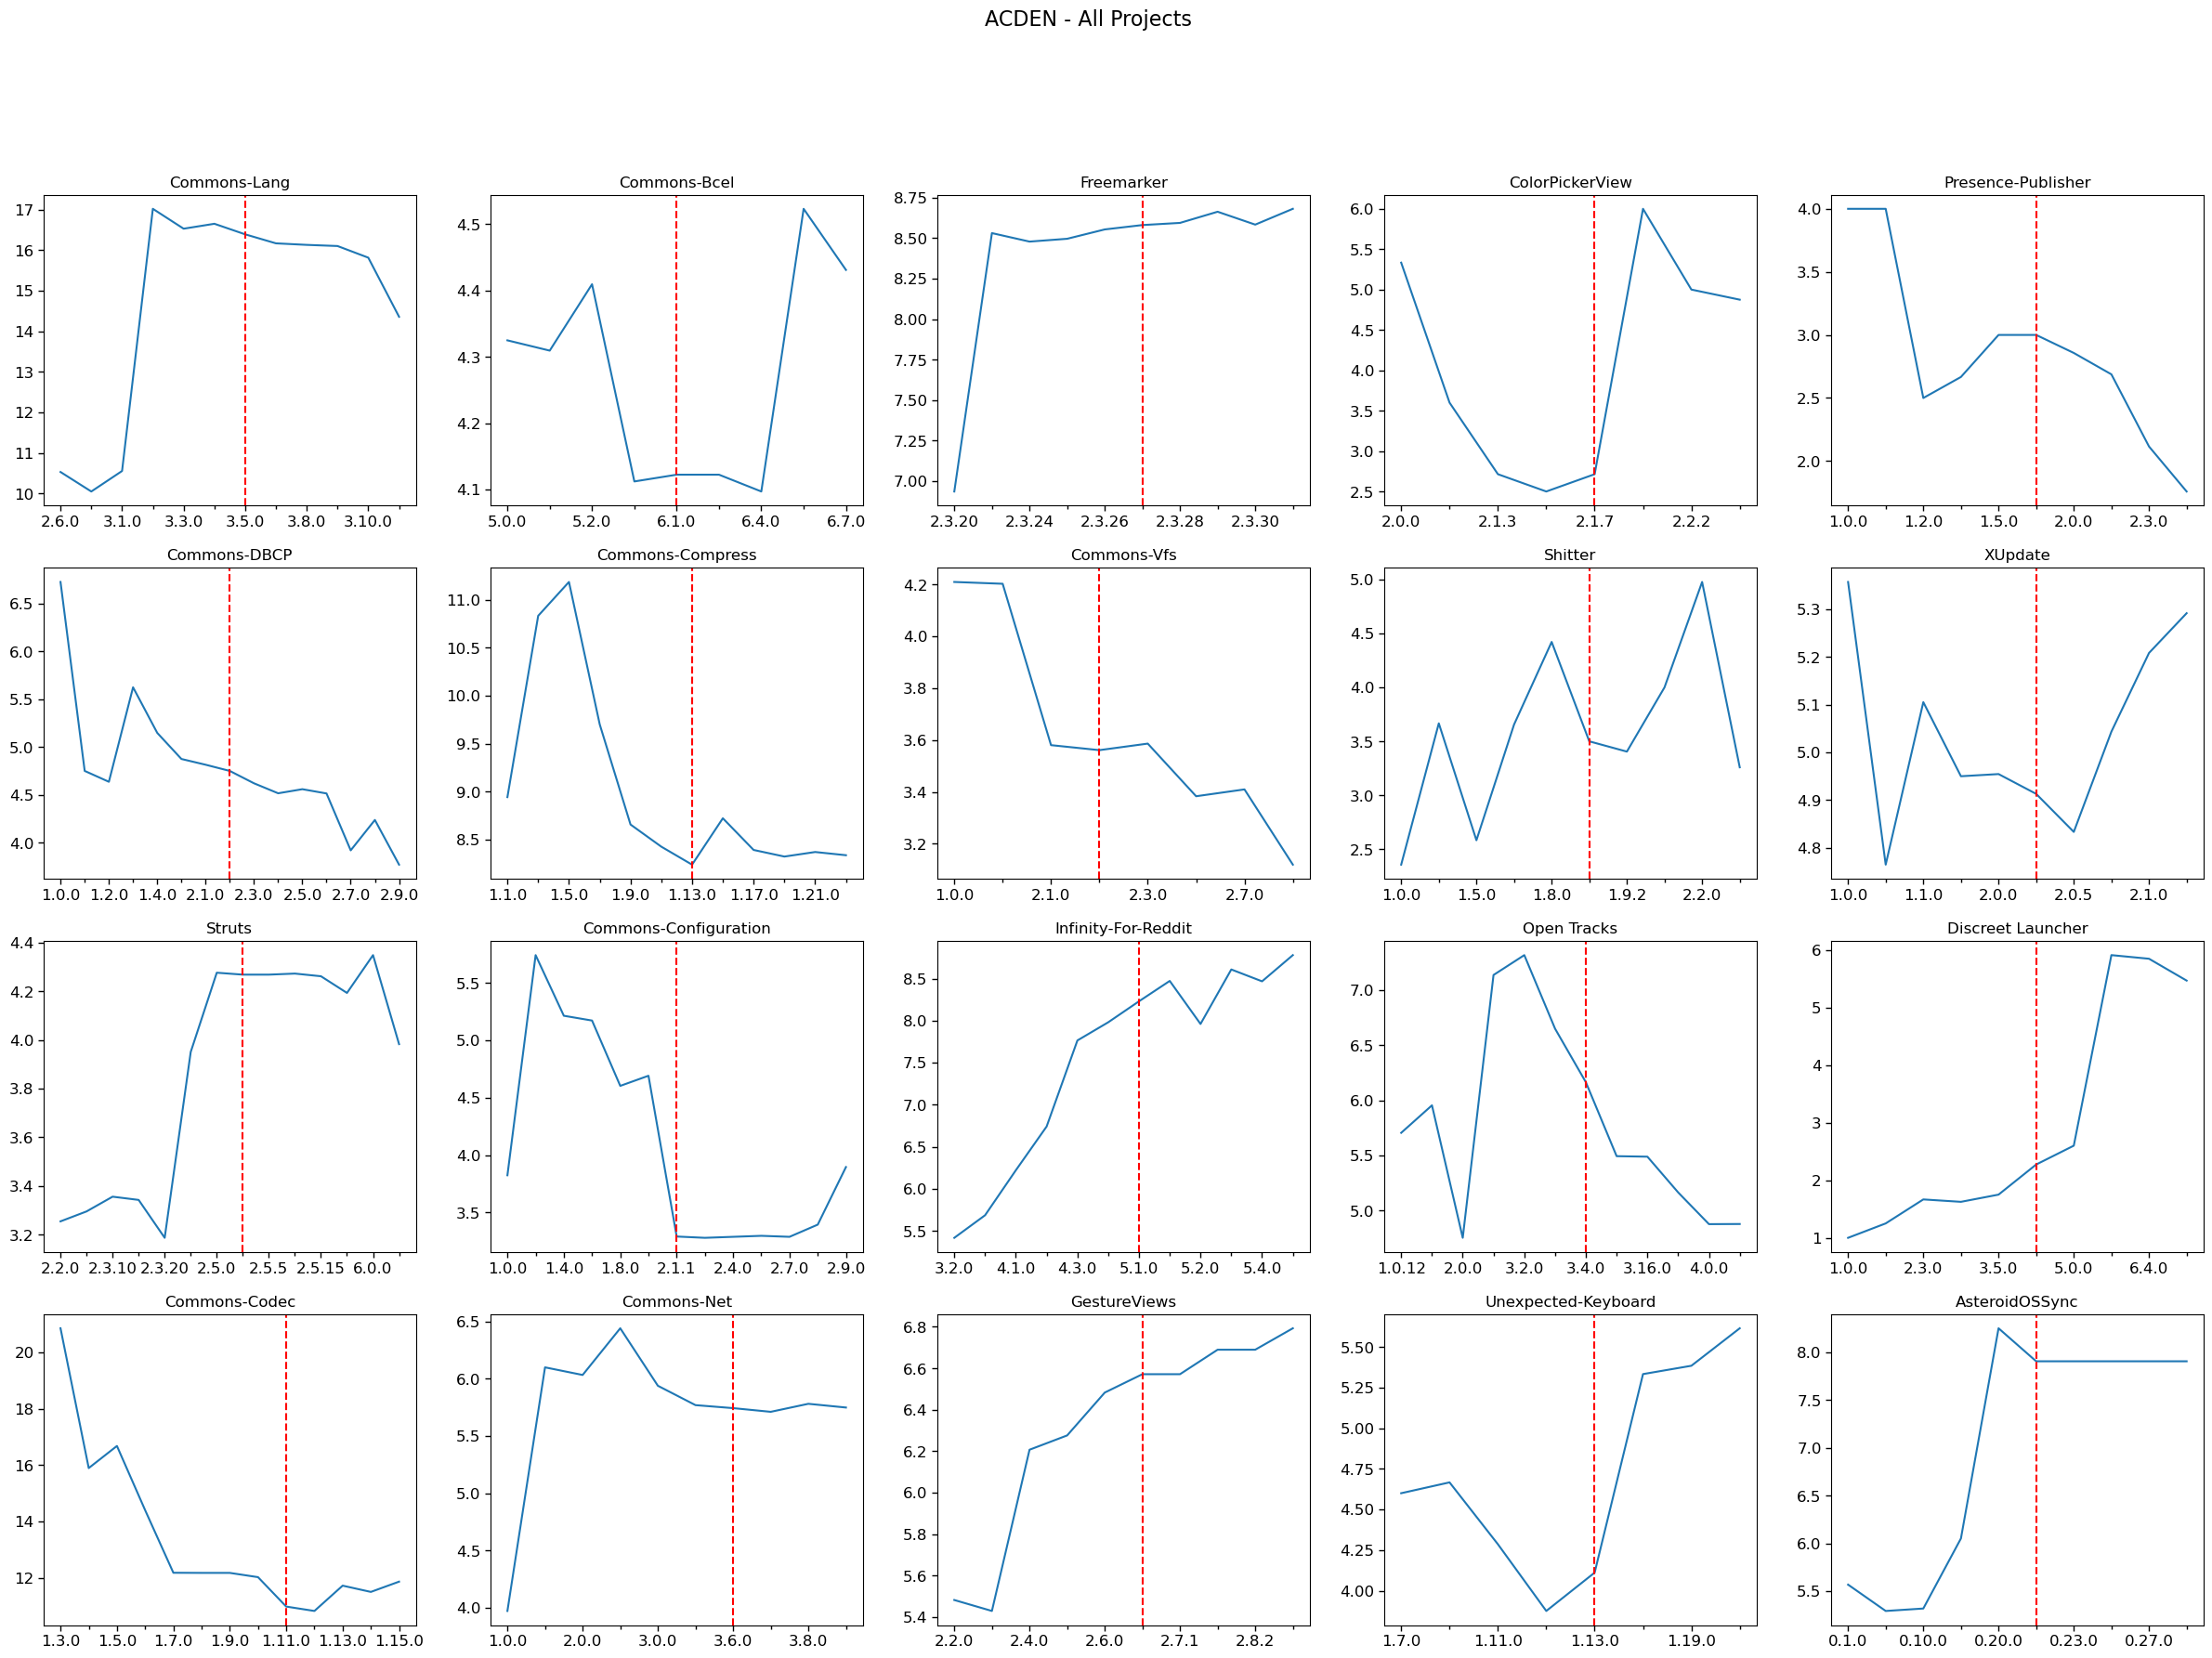

In [43]:
metrics = ['Rate', 'Diffusion', 'Density']
project_list = data_all['Project'].unique()

for j in metrics:
    fig, axs = plt.subplots(4, 5, figsize=(30,20))
    #fig.tight_layout()
    for i in range(len(project_list)):
        data_project = data_all[data_all['Project'] == project_list[i]]
        a = int(i/4)
        b = i%4
        version = get_cicd_version(data_project)
        if j == 'Rate':
            sns.lineplot(ax = axs[b,a], data=data_project, x='Version', y = 'Number of Atoms per LoC (10^-3)').set(xlabel='', ylabel='')
            axs[b,a].axvline(x=version, ymin = 0.0, ymax=1.0, color='r', linestyle ="--")
        elif j == 'Diffusion':
            sns.lineplot(ax = axs[b,a], data=data_project, x='Version', y = 'Atom Diffusion').set(xlabel='', ylabel='')
            axs[b,a].axvline(x=version, ymin = 0.0, ymax=1.0, color='r', linestyle ="--")
        elif j == 'Density':
            sns.lineplot(ax = axs[b,a], data=data_project, x='Version', y = 'Atom Density').set(xlabel='', ylabel='')
            axs[b,a].axvline(x=version, ymin = 0.0, ymax=1.0, color='r', linestyle ="--")
        axs[b,a].set_title(project_list[i])
        axs[b,a].xaxis.set_major_locator(MultipleLocator(2))
        axs[b,a].xaxis.set_minor_locator(MultipleLocator(1))
        axs[b,a].tick_params(axis='both', which='major', width=1, length=4, labelsize=12)
        axs[b,a].tick_params(axis='both', which='minor', width=1, length=3, labelsize=12)

    if(j == 'Rate'):
        fig.suptitle('ACR - All Projects', fontsize=16)
    elif(j == 'Diffusion'):
        fig.suptitle('ACDIF - All Projects', fontsize=16)
    elif(j == 'Density'):
        fig.suptitle('ACDEN - All Projects', fontsize=16)
    plt.savefig(fname='.\Output\history_' + j + '.png', dpi=100)    
    plt.show()

From here, we make calculations the geometric mean of the difference between versions, with the intention to get the growth tendency before and after CI/CD. We do this with all projects and distribution metrics.

In [44]:
def geometric_value_cicd(metric, cicd_version, data, project):
    values_before = []
    values_after = []
    differences_before = []
    differences_after = []
    cicd = False
    versions = data['Version']
    for i in versions:
        if i == cicd_version:
            cicd = True
        if cicd:
            aux = data[data['Version'] == i]
            values_after.append(float(aux[metric]))
        elif not cicd:
            aux = data[data['Version'] == i]
            values_before.append(float(aux[metric]))

    for i in range(len(values_before) - 1):
        differences_before.append(1 + (values_before[i+1] - values_before[i])/values_before[i])

    for i in range(len(values_after)):
        if i == 0:
            differences_after.append(1 + (values_after[i] - values_before[-1])/values_before[-1])
        else:
            differences_after.append(1 + (values_after[i] - values_after[i-1])/values_after[i-1])

    return (gmean(differences_before), gmean(differences_after))

In [45]:
metrics = ['Rate', 'Diffusion', 'Density']
project_list = data_all['Project'].unique()

gmeans_rate_before = []
gmeans_rate_after = []
gmeans_rate_before2 = []
gmeans_rate_after2 = []

gmeans_diffusion_before = []
gmeans_diffusion_after = []
gmeans_diffusion_before2 = []
gmeans_diffusion_after2 = []

gmeans_density_before = []
gmeans_density_after = []
gmeans_density_before2 = []
gmeans_density_after2 = []

for j in metrics:
    for i in range(len(project_list)):
        data_project = data_all[data_all['Project'] == project_list[i]]
        version = get_cicd_version(data_project)
        if j == 'Rate':
            before, after = geometric_value_cicd('Number of Atoms per LoC (10^-3)', version, data_project, project_list[i])
            gmeans_rate_before.append(before)
            gmeans_rate_after.append(after)
            gmeans_rate_before2.append((before,project_list[i]))
            gmeans_rate_after2.append((after,project_list[i]))
        elif j == 'Diffusion':
            before, after = geometric_value_cicd('Atom Diffusion', version, data_project, project_list[i])
            gmeans_diffusion_before.append(before)
            gmeans_diffusion_after.append(after)
            gmeans_diffusion_before2.append((before,project_list[i]))
            gmeans_diffusion_after2.append((after,project_list[i]))
        elif j == 'Density':
            before, after = geometric_value_cicd('Atom Density', version, data_project, project_list[i])
            gmeans_density_before.append(before)
            gmeans_density_after.append(after)
            gmeans_density_before2.append((before,project_list[i]))
            gmeans_density_after2.append((after,project_list[i]))


Finally, we already have our data, but we make a simple conversion to % format to help visualization, and we also compare by using the Wilcoxon test.

In [46]:
X = np.array(gmeans_rate_before)
Y = np.array(gmeans_rate_after)

In [47]:
np.set_printoptions(suppress = True)
print(Y*100 - 100)

[ -3.29284734  -4.38478775  -4.01541996  -0.54951038   1.32778192
  -1.96672553   0.03667518   5.09152421  -0.78655683   0.36261354
   1.14582104   1.03742005  13.26624098  -5.70011548  -2.91392761
   1.80547144 -12.42668632   0.18148682  26.38685532  -0.11707858]


In [48]:
np.array(gmeans_rate_after2)[:,1]

array(['Commons-Lang', 'Commons-DBCP', 'Struts', 'Commons-Codec',
       'Commons-Bcel', 'Commons-Compress', 'Commons-Configuration',
       'Commons-Net', 'Freemarker', 'Commons-Vfs', 'Infinity-For-Reddit',
       'GestureViews', 'ColorPickerView', 'Shitter', 'Open Tracks',
       'Unexpected-Keyboard', 'Presence-Publisher', 'XUpdate',
       'Discreet Launcher', 'AsteroidOSSync'], dtype='<U32')

In [49]:
stats.wilcoxon(X, Y)

WilcoxonResult(statistic=80.0, pvalue=0.36827659606933594)

In [50]:
stats.wilcoxon(X, Y, alternative="greater")

WilcoxonResult(statistic=130.0, pvalue=0.18413829803466797)

In [51]:
stats.wilcoxon(X, Y, alternative="less")

WilcoxonResult(statistic=130.0, pvalue=0.8255949020385742)

In [52]:
X = np.array(gmeans_diffusion_before)
Y = np.array(gmeans_diffusion_after)

In [53]:
np.set_printoptions(suppress = True)
print(X*100 - 100)

[  0.10697265   0.31846046   2.08858487  -1.72621039  -2.4589591
  -1.35386812   2.60335119   4.69478781  -5.3470098    0.91929168
   1.05140364   1.802527    23.12765003   0.64700377   1.20440298
  10.35696706  -4.89300584   5.88785677  13.28626995 -19.37933591]


In [54]:
np.array(gmeans_diffusion_after2)[:,1]

array(['Commons-Lang', 'Commons-DBCP', 'Struts', 'Commons-Codec',
       'Commons-Bcel', 'Commons-Compress', 'Commons-Configuration',
       'Commons-Net', 'Freemarker', 'Commons-Vfs', 'Infinity-For-Reddit',
       'GestureViews', 'ColorPickerView', 'Shitter', 'Open Tracks',
       'Unexpected-Keyboard', 'Presence-Publisher', 'XUpdate',
       'Discreet Launcher', 'AsteroidOSSync'], dtype='<U32')

In [55]:
print(Y*100 - 100)

[-3.07355097  0.3308162   0.02956163  1.76831407 -2.95489968 -3.00672504
 -1.2447601   1.03042742 -1.32889577 -1.24673984  0.75103203  0.
 -1.21234526 -1.70666762 -3.21990907  3.06773171 -4.51988663  1.75545772
  4.56395526  0.98057977]


In [56]:
stats.wilcoxon(X, Y)

WilcoxonResult(statistic=48.0, pvalue=0.03276824951171875)

In [57]:
stats.wilcoxon(X, Y, alternative="greater")

WilcoxonResult(statistic=162.0, pvalue=0.016384124755859375)

In [58]:
stats.wilcoxon(X, Y, alternative="less")

WilcoxonResult(statistic=162.0, pvalue=0.9852123260498047)

In [59]:
X = np.array(gmeans_density_before)
Y = np.array(gmeans_density_after)

In [60]:
np.set_printoptions(suppress = True)
print(X*100 - 100)

[  9.60131197  -5.42200733   4.65280188  -7.56706291  -1.66737801
  -1.18457603   4.1749899    7.75118113   5.38118685  -7.7785215
   8.05802373   4.28347031 -22.31918735  17.02669638   3.1118697
  -5.55666997  -6.93951409  -1.93418379  15.01633169  10.32563763]


In [61]:
np.array(gmeans_diffusion_before2)[:,1]

array(['Commons-Lang', 'Commons-DBCP', 'Struts', 'Commons-Codec',
       'Commons-Bcel', 'Commons-Compress', 'Commons-Configuration',
       'Commons-Net', 'Freemarker', 'Commons-Vfs', 'Infinity-For-Reddit',
       'GestureViews', 'ColorPickerView', 'Shitter', 'Open Tracks',
       'Unexpected-Keyboard', 'Presence-Publisher', 'XUpdate',
       'Discreet Launcher', 'AsteroidOSSync'], dtype='<U32')

In [62]:
print(Y*100 - 100)

[ -2.44035914  -3.01397892  -1.01003425  -0.26656249   1.50520963
  -0.17744177  -2.62115805  -0.09047776   0.29589662  -2.71903097
   1.60335159   0.93962231  18.17038565  -5.91537796  -5.03358275
   9.71776449 -10.13094299   1.32526131  25.58475103  -0.85131263]


In [63]:
stats.wilcoxon(X, Y)

WilcoxonResult(statistic=83.0, pvalue=0.4304332733154297)

In [64]:
stats.wilcoxon(X, Y, alternative="greater")

WilcoxonResult(statistic=127.0, pvalue=0.21521663665771484)

In [65]:
stats.wilcoxon(X, Y, alternative="less")

WilcoxonResult(statistic=127.0, pvalue=0.7954511642456055)